In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── your cleaning steps ─────────────────────────
df = pd.read_csv('spiff_data.csv')

df.rename(columns={'gurkor':'cucumbers'}, inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

mask = df.columns != 'day'
for col in df.columns[mask]:
  is_1000 = df[col] == 1000.0
  df.loc[is_1000, col] = df[col].shift(1)[is_1000]

#df.loc[:, mask] = df.loc[:, mask].replace(1000.0, np.nan)

#df['day'] = pd.to_datetime(df['day'], errors='coerce')
df['day'] = pd.to_datetime('2000-01-01') + pd.to_timedelta(df['day'] - 1, unit='D')
df.set_index('day', inplace=True)

# Drop the last 200 values, which we are supposed to extrapolate.
df = df[:-200]

# Create train and validation sets of df, using 200 values to validate
df_train = df[:-200]
df_validation = df[-200:]

# Interpolate the gaps in df_train (linear interpolation)
df_interpolated = df.interpolate(method='linear', limit_direction='both')

cucumbers_interpolated = df_interpolated['cucumbers']

#df['cucumbers'][:300].plot()
#cucumbers_interpolated[197:247].plot(color='orange')

# Create train and validation data
train_data = df_interpolated['slingshots']
true_future = df_validation['slingshots']
train_data.shape, true_future.shape

((5256,), (200,))

In [3]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.6 MB/s eta 0:00:00


In [4]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.3 MB/s eta 0:00:00


In [5]:
# Required for pmdarima (auto_arima) to work
!pip install numpy==1.24.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is 

In [7]:
df

,cucumbers,guitars,slingshots,stocks,sugar,water,tranquillity
day,,,,,,,
2000-01-01,6.154653,2.794285,2.136536,10.653684,3.324896,3.896149,7.755880
2000-01-02,6.189623,2.843068,2.113582,10.674465,3.355736,3.899915,7.781310
2000-01-03,6.168641,2.839644,2.116336,10.822372,3.336461,3.897404,7.886205
2000-01-04,6.156401,2.823384,2.096137,10.848804,3.288274,3.901170,7.848061
2000-01-05,6.124929,2.832798,2.099810,10.860731,3.303694,3.905355,7.883026
...,...,...,...,...,...,...,...
2014-05-18,13.790362,8.236738,6.451460,6.706903,2.972465,8.751953,11.767324
2014-05-19,13.798624,8.134064,6.406032,6.677940,2.960002,8.730038,11.830896
2014-05-20,13.800276,8.191484,6.444321,6.655631,2.837448,8.748910,12.129688


# Models used for extrapolation (horizon 200)


- Naive: Last observed value is extentended 200 days into the future.

- Prophet (default, no tuning)

- Monte Carlo ARIMA+GARCH


## Validation

Use rolling window cross-validation with RMSE, MAE, and MAPE.
Compare models using statistical tests (AIC) and visualizations.

## Final Forecast:

Fit the best model (based on validation metrics) on the full 5,200 observations.
Generate 200-step-ahead forecasts with confidence intervals.

## Reporting:

Summarize results in a table comparing RMSE, MAE, and MAPE across models.
Provide plots of forecasts and confidence intervals.

# BOX-COX TRANSFORMED DATA

In [54]:
from scipy.stats import boxcox
from scipy.stats import boxcox_normmax

# --- Guerrero lambda estimation ---
def guerrero_lambda(series, period=None):
    """Approximate Guerrero method for Box-Cox lambda selection."""
    series = series.dropna()
    if (series <= 0).any():
        raise ValueError("Guerrero requires all positive values")
    if period is None:
        period = max(10, len(series) // 10)  # heuristic fallback
    rolling_var = series.rolling(window=period, center=True, min_periods=1).var()
    mean_var_ratio = rolling_var.mean() / series.var()
    return max(-2, min(2, np.log(mean_var_ratio)))

# Containers
mle_transformed = {}
guerrero_transformed = {}
lambda_results = []

# Process each column
for col in df_interpolated.columns:
    if col == 'day':
        continue
    series = df_interpolated[col].dropna()

    if (series <= 0).any():
        print(f"Skipping {col} (contains non-positive values)")
        continue

    try:
        # Box-Cox MLE
        lambda_mle = boxcox_normmax(series, method='mle')
        transformed_mle = boxcox(series, lmbda=lambda_mle)

        # Guerrero lambda
        lambda_guerrero = guerrero_lambda(series)
        transformed_guerrero = boxcox(series, lmbda=lambda_guerrero)

        # Store
        mle_transformed[col] = transformed_mle
        guerrero_transformed[col] = transformed_guerrero
        lambda_results.append({
            "Instrument": col,
            "BoxCox_MLE_Lambda": round(lambda_mle, 6),
            "BoxCox_Guerrero_Lambda": round(lambda_guerrero, 6)
        })

        print(f"{col}: MLE λ = {lambda_mle:.4f}, Guerrero λ = {lambda_guerrero:.4f}")

    except Exception as e:
        print(f"Error processing {col}: {e}")

# Create result DataFrames
df_boxcox_mle = pd.DataFrame(mle_transformed)
df_boxcox_guerrero = pd.DataFrame(guerrero_transformed)
df_lambdas = pd.DataFrame(lambda_results)
guerrero_lambdas = df_lambdas['BoxCox_Guerrero_Lambda']
mle_lambdas = df_lambdas['BoxCox_MLE_Lambda']

# fix index
series_names = ['cucumbers', 'guitars', 'slingshots', 'stocks', 'sugar', 'water', 'tranquillity']
guerrero_lambdas = pd.Series(guerrero_lambdas.values, index=series_names)
mle_lambdas = pd.Series(mle_lambdas.values, index=series_names)

cucumbers: MLE λ = -1.0249, Guerrero λ = -2.0000
guitars: MLE λ = 0.5490, Guerrero λ = -1.4090
slingshots: MLE λ = -0.0540, Guerrero λ = -1.7675
stocks: MLE λ = -2.0141, Guerrero λ = -1.6483
sugar: MLE λ = 0.2617, Guerrero λ = -1.5525
water: MLE λ = -0.0249, Guerrero λ = -2.0000
tranquillity: MLE λ = -0.8244, Guerrero λ = -1.3472


In [61]:
mle_lambdas

,0
cucumbers,-1.024928
guitars,0.549039
slingshots,-0.054016
stocks,-2.014102
sugar,0.261747
water,-0.024859
tranquillity,-0.824383


# This version uses BoxCox for ARIMA+GARCH

# Further down is a version that does not use BoxCox

In [89]:
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from collections import Counter
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller

# R§emove some version warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

results = []
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=200)

for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Prepare data
    train_data = df_interpolated[series_name][:-200]
    true_future = df_interpolated[series_name][-200:]

    train_data_boxcox = df_boxcox_mle[series_name][:-200]
    true_future_boxcox = df_boxcox_mle[series_name][-200:]

    train_data.index = pd.DatetimeIndex(train_data.index, freq='D')
    train_data_boxcox.index = pd.DatetimeIndex(train_data.index, freq='D')

    # Lambda vals to inverse boxcox transform
    lambda_val = mle_lambdas[series_name]

    returns = np.log(train_data).diff().dropna()
    returns_boxcox = np.log(train_data_boxcox / train_data_boxcox.shift(1)).dropna()

    print("RETURNS BOXCOX STATIONARY TEST")
    adf_result = adfuller(returns_boxcox)
    print(f"ADF p-value: {adf_result[1]}")

    returns.index = pd.DatetimeIndex(returns.index).to_period('D').to_timestamp(freq='D')
    returns_boxcox.index = pd.DatetimeIndex(returns_boxcox.index).to_period('D').to_timestamp(freq='D')

    # Check variance of returns
    returns_var = np.var(returns)
    print(f"Series {series_name}, Variance of returns (original): {returns_var}")
    if returns_var < 1e-6:
        print(f"⚠️ Warning: Low variance (ORIGINAL) in returns for {series_name}, ARIMA may be unstable")

    returns_var_boxcox = np.var(returns_boxcox)
    print(f"Series {series_name}, Variance of returns (BoxCox): {returns_var_boxcox}")
    if returns_var_boxcox < 1e-6:
        print(f"⚠️ Warning: Low variance (BOXCOX) in returns for {series_name}, ARIMA may be unstable")

    # Compute scaling factor for Monte Carlo simulation
    variance_ratio = returns_var / returns_var_boxcox
    scaling_factor = np.sqrt(variance_ratio)
    print(f"Series {series_name}, Scaling factor: {scaling_factor}")

    # Lists to store metrics across folds
    fold_metrics = []

    if (train_data <= 0).any() or (train_data_boxcox <= 0).any():
      print(f"⚠️ Warning: Non-positive values in train_data or train_data_boxcox for {series_name}")


    # Rolling window CV
    for fold, (train_idx, test_idx) in enumerate(tscv.split(returns_boxcox)):
        train_returns_boxcox = returns_boxcox.iloc[train_idx]
        train_prices = train_data.iloc[train_idx]

        test_prices_boxcox = train_data_boxcox.iloc[test_idx]
        test_prices = train_data.iloc[test_idx]

        # Naive baseline model
        naive_forecast = np.full(200, train_data.iloc[train_idx[-1]])
        naive_rmse = np.sqrt(((naive_forecast - train_data.iloc[test_idx]) ** 2).mean())
        naive_mae = mean_absolute_error(train_data.iloc[test_idx], naive_forecast)
        # scale mape to match prophets percentage format
        naive_mape = mean_absolute_percentage_error(train_data.iloc[test_idx], naive_forecast)*100
        fold_metrics.append({'fold': fold, 'model': 'naive', 'rmse': naive_rmse, 'mae': naive_mae, 'mape': naive_mape})

        #ARIMA order selection
        arima_model = auto_arima(train_returns_boxcox, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
        arima_order = arima_model.order
        arima_result = ARIMA(train_returns_boxcox, order=arima_order).fit()

        # Ljung - Box and ARCH-LM tests
        residuals_boxcox = arima_result.resid.dropna()
        arch_needed = False
        if len(residuals_boxcox) < 10 or np.isclose(residuals_boxcox.var(), 0):
          print(f"Fold {fold}: Residuals too few / variance ~ 0 - skip tests.")
        else:
          max_lag = min(20, len(residuals_boxcox) // 5)
          lb_p = acorr_ljungbox(residuals_boxcox, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
          arch_p = het_arch(residuals_boxcox, nlags=min(10, max_lag))[1]
          print(f"Fold {fold}, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
          print(f"Fold {fold}, ARCH-LM p={arch_p:.3f}")
          arch_needed = arch_p < 0.05

        # GARCH model

        # Default to zero if GARCH not needed
        garch_result = None
        var_garch = np.zeros(200)

        if arch_needed:
          garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 2), (2, 3), (3, 3), (4,3), (3,4)]
          best_garch_aic = float('inf')
          best_garch_order = None
          best_garch_result = None

          for garch_order in garch_orders:
              garch_model = arch_model(residuals_boxcox, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
              garch_result = garch_model.fit(disp='off')

              if garch_result.aic < best_garch_aic:
                  best_garch_aic = garch_result.aic
                  best_garch_order = garch_order
                  best_garch_result = garch_result

          # Check GARCH stationarity (sum of alpha + beta < 1)
          alpha = best_garch_result.params.get('alpha[1]', 0)
          beta = best_garch_result.params.get('beta[1]', 0)
          if alpha + beta >= 1:
              print(f"⚠️ Warning: GARCH model may be non-stationary for {series_name}, fold {fold}, alpha + beta = {alpha + beta}")

          garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
          var_garch = garch_forecast.variance.values[-1, :]

        print(" -------- GARCH VARIANCE------ ")
        print(f"Fold {fold}, Max GARCH variance: {var_garch.max()}")

        # Monte Carlo Simulation for ARIMA+GARCH on Box-Cox data
        horizon = 200
        n_simulations = 100
        last_price_boxcox = train_data_boxcox.iloc[-1]
        last_return = arima_result.resid.iloc[-1]

        phi = arima_result.params.get('ar.L1', 0)
        theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
        mu = arima_result.params.get('const', 0)

        simulated_paths_boxcox = np.zeros((n_simulations, horizon))
        for i in range(n_simulations):
            r_prev = last_return
            eps_prev = [0.0] * arima_order[2]
            sim_returns = []
            for t in range(horizon):
                std_dev = np.sqrt(var_garch[t])
                eps_t = np.random.normal(0, std_dev)

                ma_part = sum(theta[j] * eps_prev[j] for j in range(arima_order[2])) if arima_order[2] > 0 else 0

                r_t = mu + phi * r_prev + ma_part + eps_t
                sim_returns.append(r_t)

                r_prev = r_t
                eps_prev = [eps_t] + eps_prev[:-1]

            # Cumulative log returns and exponentiate to get back to Box-Cox scale
            sim_log_values = np.log(last_price_boxcox) + np.cumsum(sim_returns)
            sim_values_boxcox = np.exp(sim_log_values)
            simulated_paths_boxcox[i, :] = sim_values_boxcox

        # Debug: Check for extreme values
        max_boxcox = np.max(simulated_paths_boxcox)
        min_boxcox = np.min(simulated_paths_boxcox)
        print(f"Fold {fold}, Series {series_name}, Max simulated prices (boxcox): {max_boxcox}")
        print(f"Fold {fold}, Series {series_name}, Min simulated prices (boxcox): {min_boxcox}")


        simulated_paths = np.zeros((n_simulations, horizon))

        # Clip so that we don't get NaN when inverse boxcox.
        # This might cause some problems, however no solution found.
        if lambda_val < 0:
          max_valid = 1 / abs(lambda_val)
          print(f"Fold {fold}, Series {series_name}, Clipping sim_values_boxcox to max {max_valid}")
          simulated_paths_boxcox = np.clip(simulated_paths_boxcox, 1e-10, max_valid * 0.999)  # Slight buffer

        for i in range(n_simulations):
            simulated_paths[i, :] = inv_boxcox(simulated_paths_boxcox[i, :], lambda_val)

        if np.any(np.isnan(simulated_paths)):
            print(f"⚠️ Warning: NaN values in simulated paths for {series_name} in final forecast")
            # Debug: identify problematic values
            for i in range(n_simulations):
              if np.any(np.isnan(simulated_paths[i, :])):
                print(f"NaN in simulation {i}, sim_values_boxcox: min={np.min(simulated_paths_boxcox[i, :])}, max={np.max(simulated_paths_boxcox[i, :])}")

        arima_garch_forecast = simulated_paths.mean(axis=0)
        arima_garch_lower_bound = np.percentile(simulated_paths, 5, axis=0)
        arima_garch_upper_bound = np.percentile(simulated_paths, 95, axis=0)

        print(f"Fold {fold}, Max simulated prices: {simulated_paths.max()}")
        print(f"Fold {fold}, Max point forecast: {arima_garch_forecast.max()}")

        rmse = np.sqrt(((arima_garch_forecast - test_prices) ** 2).mean())
        mae = mean_absolute_error(test_prices, arima_garch_forecast)
        mape = mean_absolute_percentage_error(test_prices, arima_garch_forecast) * 100 # Scale mape to match prophet's percentage format

        fold_metrics.append({
            'fold': fold,
            'model': 'arima_garch',
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'arima_order': arima_order,
            'garch_order': best_garch_order if arch_needed else None
        })

    # Average metrics across folds
    metrics_df = pd.DataFrame(fold_metrics)
    avg_metrics = metrics_df.groupby('model')[['rmse', 'mae', 'mape']].mean().reset_index()

    # Store CV results
    for _, row in avg_metrics.iterrows():
        result = {
            'series': series_name,
            'model': row['model'],
            'rmse': row['rmse'],
            'mae': row['mae'],
            'mape': row['mape']
        }
        if row['model'] == 'arima_garch':
            # Get most frequent orders across folds
            arima_orders = [str(m['arima_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            garch_orders = [str(m['garch_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            result['arima_order'] = eval(Counter(arima_orders).most_common(1)[0][0])
            result['garch_order'] = eval(Counter(garch_orders).most_common(1)[0][0])
        results.append(result)


    # ---------------  Final Forecasts ------------
    # Use full df_interpolated
    train_data = df_interpolated[series_name]
    train_data_boxcox = df_boxcox_mle[series_name]
    returns_boxcox = np.log(train_data_boxcox / train_data_boxcox.shift(1)).dropna()

    #Generate future dates for 200 days beyond the last observation
    last_date = train_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=200, freq='D')

    # Naive Baseline
    naive_final_forecast = np.full(200, train_data.iloc[-1])
    #Estimate confidence intervals based on histrocial standard deivation
    hist_std = train_data.diff().dropna().std() * np.sqrt(np.arange(1,201))
    naive_lower_bound = naive_final_forecast - 1.96 * hist_std
    naive_upper_bound = naive_final_forecast + 1.96 * hist_std

    results.append({
        'series': series_name,
        'model': 'naive',
        'final_forecast': naive_final_forecast,
        'lower_bound': naive_lower_bound,
        'upper_bound': naive_upper_bound,
        'forecast_dates': future_dates
    })

    # ARIMA order selection
    arima_model = auto_arima(returns_boxcox, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
    arima_order = arima_model.order
    arima_result = ARIMA(returns_boxcox, order=arima_order).fit()

    # Ljung-Box and ARCH-LM tests
    residuals_boxcox = arima_result.resid.dropna()
    arch_needed = False

    if len(residuals_boxcox) < 10 or np.isclose(residuals_boxcox.var(), 0):
        print("⚠️ Final Forecast: Residuals too few / variance ≈ 0 – skip tests.")
    else:
        max_lag = min(20, len(residuals_boxcox)//5)
        lb_p = acorr_ljungbox(residuals_boxcox, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
        arch_p = het_arch(residuals_boxcox, nlags=min(10, max_lag))[1]
        print(f"⚠️ Final Forecast, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
        print(f"⚠️ Final Forecast, ARCH-LM p={arch_p:.3f}")
        arch_needed = arch_p < 0.05

    garch_result = None
    var_garch = np.zeros(200)

    if arch_needed:
      garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 2), (2, 3), (3, 3)]
      best_garch_aic = float('inf')
      best_garch_order = None
      best_garch_result = None

      for garch_order in garch_orders:
          garch_model = arch_model(residuals_boxcox, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
          garch_result = garch_model.fit(disp='off')
          if garch_result.aic < best_garch_aic:
              best_garch_aic = garch_result.aic
              best_garch_order = garch_order
              best_garch_result = garch_result

      if best_garch_result is not None:
            std_resid = best_garch_result.std_resid.dropna()

            # Ljung-Box on standardized residuals
            lb_p_post = acorr_ljungbox(std_resid, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]

            # ARCH-LM test on stadardized residuals
            arch_p_post = het_arch(std_resid, nlags=min(10, max_lag))[1]

            print(f"⚠️ Post-GARCH Ljung-Box p = {lb_p_post:.3f}")
            print(f"⚠️ Post-GARCH ARCH-LM p = {arch_p_post:.3f}")

      garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
      var_garch = garch_forecast.variance.values[-1, :]

    # Monte Carlo Simulation for ARIMA+GARCH on Box-Cox data
    horizon = 200
    n_simulations = 100
    last_price_boxcox = train_data_boxcox.iloc[-1]
    last_return = arima_result.resid.iloc[-1]

    phi = arima_result.params.get('ar.L1', 0)
    theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
    mu = arima_result.params.get('const', 0)

    simulated_paths_boxcox = np.zeros((n_simulations, horizon))
    for i in range(n_simulations):

      r_prev = last_return  # Scalar for each simulation
      eps_prev = [0.0] * arima_order[2]  # History of shocks for this simulation

      sim_returns = []
      for t in range(horizon):
          std_dev = np.sqrt(var_garch[t])
          eps_t = np.random.normal(0, std_dev)  # Scalar shock for this simulation

          ma_part = sum(theta[j] * eps_prev[j] for j in range(arima_order[2])) if arima_order[2] > 0 else 0
          r_t = mu + phi * r_prev + ma_part + eps_t

          sim_returns.append(r_t)
          r_prev = r_t
          eps_prev = [eps_t] + eps_prev[:-1]

      # Cumulative log returns and exponentiate to get back to Box-Cox scale
      sim_log_values = np.log(last_price_boxcox) + np.cumsum(sim_returns)
      sim_values_boxcox = np.exp(sim_log_values)
      simulated_paths_boxcox[i, :] = sim_values_boxcox

    max_boxcox = np.max(simulated_paths_boxcox)
    print(f"Max simulated prices (boxcox): {max_boxcox}")
    min_boxcox = np.min(simulated_paths_boxcox)
    print(f"Min simulated prices (boxcox): {min_boxcox}")

    # Inverse BoxCox
    simulated_paths = np.zeros((n_simulations, horizon))
    if lambda_val < 0:
      max_valid = 1 / abs(lambda_val)
      print(f"Fold {fold}, Series {series_name}, Clipping sim_values_boxcox to max {max_valid}")
      simulated_paths_boxcox = np.clip(simulated_paths_boxcox, 1e-10, max_valid * 0.999)
    for i in range(n_simulations):
        simulated_paths[i, :] = inv_boxcox(simulated_paths_boxcox[i, :], lambda_val)

    if np.any(np.isnan(simulated_paths)):
        print(f"⚠️ Warning: NaN values in simulated paths for {series_name} in final forecast")
        for i in range(n_simulations):
            if np.any(np.isnan(simulated_paths[i, :])):
                print(f"NaN in simulation {i}, sim_values_boxcox: min={np.min(simulated_paths_boxcox[i, :])}, max={np.max(simulated_paths_boxcox[i, :])}")

    arima_garch_final_forecast = simulated_paths.mean(axis=0)
    arima_garch_lower_bound = np.percentile(simulated_paths, 5, axis=0)
    arima_garch_upper_bound = np.percentile(simulated_paths, 95, axis=0)

    results.append({
        'series': series_name,
        'model': 'arima_garch',
        'final_forecast': arima_garch_final_forecast,
        'lower_bound': arima_garch_lower_bound,
        'upper_bound': arima_garch_upper_bound,
        'forecast_dates': future_dates,
        'arima_order': arima_order,
        'garch_order': best_garch_order if arch_needed else None
    })


# Summary of CV results
results_df = pd.DataFrame([r for r in results if 'rmse' in r])
print("Cross-Validation Results Summary:")
print(results_df[['series', 'model', 'rmse', 'mae', 'mape', 'arima_order', 'garch_order']])

# Final forecasts
forecast_df = pd.DataFrame([r for r in results if 'final_forecast' in r])
print("\nFinal Forecasts:")
print(forecast_df[['series', 'model', 'final_forecast', 'lower_bound', 'upper_bound']])

RETURNS BOXCOX STATIONARY TEST
ADF p-value: 0.0
Series cucumbers, Variance of returns (original): 1.5827989170076743e-05
Series cucumbers, Variance of returns (BoxCox): 2.813602224833022e-07
⚠️ Warning: Low variance (BOXCOX) in returns for cucumbers, ARIMA may be unstable
Series cucumbers, Scaling factor: 7.500349876737042


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:

Fold 0, Ljung-Box p=0.027 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 9.5401455479482e-07
Fold 0, Series cucumbers, Max simulated prices (boxcox): 0.9381523392428259
Fold 0, Series cucumbers, Min simulated prices (boxcox): 0.8824922516247538
Fold 0, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
Fold 0, Max simulated prices: 24.01929811888286
Fold 0, Max point forecast: 14.467513816865393


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Fold 1, Ljung-Box p=0.028 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 3.1247210988228807e-07
Fold 1, Series cucumbers, Max simulated prices (boxcox): 0.9286408494291549
Fold 1, Series cucumbers, Min simulated prices (boxcox): 0.8918320833248744
Fold 1, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
Fold 1, Max simulated prices: 19.267909095321247
Fold 1, Max point forecast: 14.239252340020947


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints

Fold 2, Ljung-Box p=0.009 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 2.90887907481485e-07
Fold 2, Series cucumbers, Max simulated prices (boxcox): 0.9332663803348814
Fold 2, Series cucumbers, Min simulated prices (boxcox): 0.8962796489519039
Fold 2, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
Fold 2, Max simulated prices: 21.315574331452336
Fold 2, Max point forecast: 14.525313858994132


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints

Fold 3, Ljung-Box p=0.006 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 2.7974247060113685e-07
Fold 3, Series cucumbers, Max simulated prices (boxcox): 0.9258390235440255
Fold 3, Series cucumbers, Min simulated prices (boxcox): 0.8916838849058959
Fold 3, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
Fold 3, Max simulated prices: 18.21032871432483
Fold 3, Max point forecast: 14.090308181347973
Fold 4, Ljung-Box p=0.005 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 2.7944867048697695e-07
Fold 4, Series cucumbers, Max simulated prices (boxcox): 0.9261289182363591
Fold 4, Series cucumbers, Min simulated prices (boxcox): 0.8969977332887287
Fold 4, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
Fold 4, Max simulated prices: 18.314271819448223
Fold 4, Max point forecast: 14.57925230080117


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/

⚠️ Final Forecast, Ljung-Box p=0.002 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


⚠️ Post-GARCH Ljung-Box p = 0.019
⚠️ Post-GARCH ARCH-LM p = 0.627
Max simulated prices (boxcox): 0.9281285831718585
Min simulated prices (boxcox): 0.8994299529353151
Fold 4, Series cucumbers, Clipping sim_values_boxcox to max 0.9756782915482843
RETURNS BOXCOX STATIONARY TEST
ADF p-value: 3.9618926222155505e-21
Series guitars, Variance of returns (original): 0.0002254188941233319
Series guitars, Variance of returns (BoxCox): 0.00020088801509512839
Series guitars, Scaling factor: 1.0592979787209233
Fold 0, Ljung-Box p=0.029 (lag 20)
Fold 0, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0007177628246533103
Fold 0, Series guitars, Max simulated prices (boxcox): 6.030797317533606
Fold 0, Series guitars, Min simulated prices (boxcox): 1.711399308636619
Fold 0, Max simulated prices: 14.316074248583444
Fold 0, Max point forecast: 7.5571787909136585
Fold 1, Ljung-Box p=0.002 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.0002477990203152369
Fold 1, Series guitars, Max simulated prices (boxcox): 5.9931013723013
Fold 1, Series guitars, Min simulated prices (boxcox): 2.1616291236396243
Fold 1, Max simulated prices: 14.191143647999278
Fold 1, Max point forecast: 7.939287921013452
Fold 2, Ljung-Box p=0.001 (lag 20)
Fold 2, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.00020407077701112503
Fold 2, Series guitars, Max simulated prices (boxcox): 5.576211713931111
Fold 2, Series guitars, Min simulated prices (boxcox): 2.1594574031166522
Fold 2, Max simulated prices: 12.842541688853084
Fold 2, Max point forecast: 7.417667074949925
Fold 3, Ljung-Box p=0.003 (lag 20)
Fold 3, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.0001694404140038677
Fold 3, Series guitars, Max simulated prices (boxcox): 6.136823144858821
Fold 3, Series guitars, Min simulated prices (boxcox): 2.439618856709678
Fold 3,

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


⚠️ Final Forecast, Ljung-Box p=0.000 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.397
⚠️ Post-GARCH ARCH-LM p = 0.896
Max simulated prices (boxcox): 6.365410660719226
Min simulated prices (boxcox): 2.4205276817049906
RETURNS BOXCOX STATIONARY TEST
ADF p-value: 0.0
Series slingshots, Variance of returns (original): 0.00021955795572236217
Series slingshots, Variance of returns (BoxCox): 0.0001576832211415469
Series slingshots, Scaling factor: 1.1799995662964133
Fold 0, Ljung-Box p=0.058 (lag 20)
Fold 0, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0008139313711338699
Fold 0, Series slingshots, Max simulated prices (boxcox): 3.367451886619545
Fold 0, Series slingshots, Min simulated prices (boxcox): 0.8241110095185563
Fold 0, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
Fold 0, Max simulated prices: 41.13216762072235
Fold 0, Max point forecast: 6.2383227647604995
Fold 1, Ljung-Box p=0.135 (lag 20)
Fold

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 2, Ljung-Box p=0.023 (lag 20)
Fold 2, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.0001579237990847019
Fold 2, Series slingshots, Max simulated prices (boxcox): 2.4060138319313804
Fold 2, Series slingshots, Min simulated prices (boxcox): 1.0452569451079126
Fold 2, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
Fold 2, Max simulated prices: 13.162621750562476
Fold 2, Max point forecast: 5.662743435612047
Fold 3, Ljung-Box p=0.297 (lag 20)
Fold 3, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.0001647378631316887
Fold 3, Series slingshots, Max simulated prices (boxcox): 2.6021137857205527
Fold 3, Series slingshots, Min simulated prices (boxcox): 1.0627840688252452
Fold 3, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
Fold 3, Max simulated prices: 16.51315187098114
Fold 3, Max point forecast: 5.891023114078102


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 4, Ljung-Box p=0.004 (lag 20)
Fold 4, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.00021847102095162268
Fold 4, Series slingshots, Max simulated prices (boxcox): 3.35845842423767
Fold 4, Series slingshots, Min simulated prices (boxcox): 1.054896005354593
Fold 4, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
Fold 4, Max simulated prices: 40.68260828202619
Fold 4, Max point forecast: 6.646991206138964


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


⚠️ Final Forecast, Ljung-Box p=0.005 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


⚠️ Post-GARCH Ljung-Box p = 0.003
⚠️ Post-GARCH ARCH-LM p = 0.995
Max simulated prices (boxcox): 2.5525948950763024
Min simulated prices (boxcox): 1.3212014098221996
Fold 4, Series slingshots, Clipping sim_values_boxcox to max 18.51303317535545
RETURNS BOXCOX STATIONARY TEST
ADF p-value: 0.0
Series stocks, Variance of returns (original): 0.00021966421013982172
Series stocks, Variance of returns (BoxCox): 1.044184334176792e-06
Series stocks, Scaling factor: 14.504109336739743
Fold 0, Ljung-Box p=0.279 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 1.534016332667618e-06
Fold 0, Series stocks, Max simulated prices (boxcox): 0.49444087381323265
Fold 0, Series stocks, Min simulated prices (boxcox): 0.4545183826614403
Fold 0, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
Fold 0, Max simulated prices: 15.235736784623194
Fold 0, Max point forecast: 5.112287666957076
Fold 1, Ljung-Box p=0.205 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 1.7231224967377127e-06
Fold 1, Series stocks, Max simulated prices (boxcox): 0.5008212323010834
Fold 1, Series stocks, Min simulated prices (boxcox): 0.45639496466822055
Fold 1, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
Fold 1, Max simulated prices: 30.86722251989976
Fold 1, Max point forecast: 5.710593745907163


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:

Fold 2, Ljung-Box p=0.335 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 1.124062849276093e-06
Fold 2, Series stocks, Max simulated prices (boxcox): 0.4934342088089528
Fold 2, Series stocks, Min simulated prices (boxcox): 0.46176720304716823
Fold 2, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
Fold 2, Max simulated prices: 12.502899700861615
Fold 2, Max point forecast: 5.215144367262935
Fold 3, Ljung-Box p=0.198 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 1.0228529439742061e-06
Fold 3, Series stocks, Max simulated prices (boxcox): 0.4973224934451589
Fold 3, Series stocks, Min simulated prices (boxcox): 0.46192655556506584
Fold 3, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
Fold 3, Max simulated prices: 30.86722251989976
Fold 3, Max point forecast: 5.4138567392885015
Fold 4, Ljung-Box p=0.289 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 1.284397095135389e-06
Fold 4, Series stocks, Max simulated prices (boxcox): 0.4966016219610514
Fold 4, Series stocks, Min simulated prices (boxcox): 0.4579697446345135
Fold 4, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
Fold 4, Max simulated prices: 30.86722251989976
Fold 4, Max point forecast: 5.552883123568479


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

⚠️ Final Forecast, Ljung-Box p=0.225 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


⚠️ Post-GARCH Ljung-Box p = 0.978
⚠️ Post-GARCH ARCH-LM p = 0.365
Max simulated prices (boxcox): 0.5005486330946697
Min simulated prices (boxcox): 0.4666433469507883
Fold 4, Series stocks, Clipping sim_values_boxcox to max 0.4964991842518403
RETURNS BOXCOX STATIONARY TEST
ADF p-value: 2.4835478881035977e-22
Series sugar, Variance of returns (original): 0.00023005582357194527
Series sugar, Variance of returns (BoxCox): 0.0005639791784413065
Series sugar, Scaling factor: 0.638682593850139
Fold 0, Ljung-Box p=0.619 (lag 20)
Fold 0, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0074304425378807475
Fold 0, Series sugar, Max simulated prices (boxcox): 16.365216936865327
Fold 0, Series sugar, Min simulated prices (boxcox): 0.060738609598221444
Fold 0, Max simulated prices: 577.9959470688515
Fold 0, Max point forecast: 12.782603752973856


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1, Ljung-Box p=0.001 (lag 20)
Fold 1, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.0006045837886011612
Fold 1, Series sugar, Max simulated prices (boxcox): 1.9445465492796357
Fold 1, Series sugar, Min simulated prices (boxcox): 0.33666518349624863
Fold 1, Max simulated prices: 4.815666300354901
Fold 1, Max point forecast: 1.9563213309589138
Fold 2, Ljung-Box p=0.005 (lag 20)
Fold 2, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.0005519495882350089
Fold 2, Series sugar, Max simulated prices (boxcox): 1.6318644553380146
Fold 2, Series sugar, Min simulated prices (boxcox): 0.2967868038781038
Fold 2, Max simulated prices: 3.891632967343862
Fold 2, Max point forecast: 1.9402840432072563
Fold 3, Ljung-Box p=0.010 (lag 20)
Fold 3, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.0005507262475299425
Fold 3, Series sugar, Max simulated prices (boxcox): 1.3213056583325278
Fold 3, Series sugar, Min 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


⚠️ Final Forecast, Ljung-Box p=0.029 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.000
⚠️ Post-GARCH ARCH-LM p = 0.885
Max simulated prices (boxcox): 3.0368945815564214
Min simulated prices (boxcox): 0.5006204902150938
RETURNS BOXCOX STATIONARY TEST
ADF p-value: 0.0
Series water, Variance of returns (original): 1.2326905302187694e-05
Series water, Variance of returns (BoxCox): 4.167863782354644e-06
Series water, Scaling factor: 1.7197696150693638
Fold 0, Ljung-Box p=0.193 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 1.0035090192644597e-05
Fold 0, Series water, Max simulated prices (boxcox): 2.3553086021599796
Fold 0, Series water, Min simulated prices (boxcox): 1.9480995555738123
Fold 0, Series water, Clipping sim_values_boxcox to max 40.22687960094935
Fold 0, Max simulated prices: 11.32572252284853
Fold 0, Max point forecast: 8.90436579025659
Fold 1, Ljung-Box p=0.064 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 4.118046228344917e-06
Fold 1, Series water, Max simulated prices (boxcox): 2.2652734399110193
Fold 1, Series water, Min simulated prices (boxcox): 1.9253917906586406
Fold 1, Series water, Clipping sim_values_boxcox to max 40.22687960094935
Fold 1, Max simulated prices: 10.293939661276763
Fold 1, Max point forecast: 8.852420168044505
Fold 2, Ljung-Box p=0.067 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 3.7473347582331066e-06
Fold 2, Series water, Max simulated prices (boxcox): 2.282475441956718
Fold 2, Series water, Min simulated prices (boxcox): 1.9503278943850022
Fold 2, Series water, Clipping sim_values_boxcox to max 40.22687960094935
Fold 2, Max simulated prices: 10.483346639888003
Fold 2, Max point forecast: 8.804413466009507


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:

Fold 3, Ljung-Box p=0.096 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 3.889140714877904e-06
Fold 3, Series water, Max simulated prices (boxcox): 2.2838950325166976
Fold 3, Series water, Min simulated prices (boxcox): 1.9159589581782916
Fold 3, Series water, Clipping sim_values_boxcox to max 40.22687960094935
Fold 3, Max simulated prices: 10.499136076402529
Fold 3, Max point forecast: 8.69410759971481
Fold 4, Ljung-Box p=0.077 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 1.0229840218032917e-05
Fold 4, Series water, Max simulated prices (boxcox): 2.375657330524168
Fold 4, Series water, Min simulated prices (boxcox): 1.9213972725956439
Fold 4, Series water, Clipping sim_values_boxcox to max 40.22687960094935
Fold 4, Max simulated prices: 11.573251537765012
Fold 4, Max point forecast: 8.985211945072257


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


⚠️ Final Forecast, Ljung-Box p=0.150 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

⚠️ Post-GARCH Ljung-Box p = 0.748
⚠️ Post-GARCH ARCH-LM p = 0.981
Max simulated prices (boxcox): 2.2909502860211
Min simulated prices (boxcox): 1.972136676344759
Fold 4, Series water, Clipping sim_values_boxcox to max 40.22687960094935
RETURNS BOXCOX STATIONARY TEST
ADF p-value: 0.0
Series tranquillity, Variance of returns (original): 0.00015742639415925125
Series tranquillity, Variance of returns (BoxCox): 2.5652740574310284e-06
Series tranquillity, Scaling factor: 7.833789354220665


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 0, Ljung-Box p=0.772 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 3.2418803926800767e-06
Fold 0, Series tranquillity, Max simulated prices (boxcox): 1.2889938646323815
Fold 0, Series tranquillity, Min simulated prices (boxcox): 0.9221607132577588
Fold 0, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Fold 0, Max simulated prices: 4355.973520032846
Fold 0, Max point forecast: 59.02424852893341
Fold 1, Ljung-Box p=0.342 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 7.785220143667775e-06
Fold 1, Series tranquillity, Max simulated prices (boxcox): 1.270824009152845
Fold 1, Series tranquillity, Min simulated prices (boxcox): 0.8948832599027849
Fold 1, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Fold 1, Max simulated prices: 4355.973520032846
Fold 1, Max point forecast: 351.4224001408882


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2, Ljung-Box p=0.288 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 4.23725412802882e-06
Fold 2, Series tranquillity, Max simulated prices (boxcox): 1.2112356226916612
Fold 2, Series tranquillity, Min simulated prices (boxcox): 0.9341811659067465
Fold 2, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Fold 2, Max simulated prices: 2711.973268569652
Fold 2, Max point forecast: 41.71968941894331


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:

Fold 3, Ljung-Box p=0.040 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 2.6082862901552337e-06
Fold 3, Series tranquillity, Max simulated prices (boxcox): 1.1269918244225785
Fold 3, Series tranquillity, Min simulated prices (boxcox): 0.9994610037542052
Fold 3, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Fold 3, Max simulated prices: 24.77407540954187
Fold 3, Max point forecast: 12.759052080463944


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Fold 4, Ljung-Box p=0.145 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 3.1058241981900817e-06
Fold 4, Series tranquillity, Max simulated prices (boxcox): 1.1678265595032191
Fold 4, Series tranquillity, Min simulated prices (boxcox): 0.9207944695620004
Fold 4, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Fold 4, Max simulated prices: 54.08434666621005
Fold 4, Max point forecast: 14.657592575472492


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


⚠️ Final Forecast, Ljung-Box p=0.013 (lag 20)
⚠️ Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

⚠️ Post-GARCH Ljung-Box p = 0.081
⚠️ Post-GARCH ARCH-LM p = 0.935
Max simulated prices (boxcox): 1.11882878674205
Min simulated prices (boxcox): 1.00017421964124
Fold 4, Series tranquillity, Clipping sim_values_boxcox to max 1.2130284103383986
Cross-Validation Results Summary:
          series        model       rmse        mae        mape arima_order  \
0      cucumbers  arima_garch   1.994229   1.969261   16.990062   (0, 0, 0)   
1      cucumbers        naive   0.603771   0.527199    4.327554         NaN   
2        guitars  arima_garch   1.621627   1.507188   28.314986   (1, 0, 1)   
3        guitars        naive   0.734892   0.604169   10.852479         NaN   
4     slingshots  arima_garch   1.586638   1.517894   43.844706   (2, 0, 1)   
5     slingshots        naive   0.514113   0.450496   11.851226         NaN   
6         stocks  arima_garch   0.452686   0.405229    8.419165   (0, 0, 0)   
7         stocks        naive   0.497413   0.422601    8.520884         NaN   
8          

In [90]:
results_df

,series,model,rmse,mae,mape,arima_order,garch_order
0,cucumbers,arima_garch,1.994229,1.969261,16.990062,"(0, 0, 0)","(2, 3)"
1,cucumbers,naive,0.603771,0.527199,4.327554,NaN,NaN
2,guitars,arima_garch,1.621627,1.507188,28.314986,"(1, 0, 1)","(3, 3)"
3,guitars,naive,0.734892,0.604169,10.852479,NaN,NaN
4,slingshots,arima_garch,1.586638,1.517894,43.844706,"(2, 0, 1)","(2, 2)"
5,slingshots,naive,0.514113,0.450496,11.851226,NaN,NaN
6,stocks,arima_garch,0.452686,0.405229,8.419165,"(0, 0, 0)","(3, 4)"
7,stocks,naive,0.497413,0.422601,8.520884,NaN,NaN
8,sugar,arima_garch,0.662162,0.484357,26.996585,"(1, 0, 0)","(2, 3)"
9,sugar,naive,0.230337,0.200665,11.032426,NaN,NaN


In [91]:
forecast_df

,series,model,final_forecast,lower_bound,upper_bound,forecast_dates,arima_order,garch_order
0,cucumbers,naive,"[13.79194942177011, 13.79194942177011, 13.7919...","[13.720359948451321, 13.690706617679533, 13.66...","[13.863538895088897, 13.893192225860686, 13.91...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
1,cucumbers,arima_garch,"[13.797128622612021, 13.794881210328699, 13.79...","[13.715239729013566, 13.67239524619866, 13.644...","[13.877687525598201, 13.943219254887019, 13.96...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(0, 0, 0)","(2, 3)"
2,guitars,naive,"[8.08491746257293, 8.08491746257293, 8.0849174...","[7.9173134493709725, 7.847889593994562, 7.7946...","[8.252521475774888, 8.321945331151298, 8.37521...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
3,guitars,arima_garch,"[8.086304428233428, 8.09384081622818, 8.094552...","[7.9739530440460085, 7.930733142665136, 7.8652...","[8.203675686092135, 8.273030888279532, 8.30989...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(0, 0, 0)","(3, 3)"
4,slingshots,naive,"[6.419011268155251, 6.419011268155251, 6.41901...","[6.31587819759022, 6.273159081033004, 6.240379...","[6.522144338720282, 6.564863455277498, 6.59764...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
5,slingshots,arima_garch,"[6.416029608411265, 6.418790218792489, 6.42841...","[6.2889204929908065, 6.306250609874552, 6.2801...","[6.5147938811423804, 6.585263263380014, 6.5901...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(3, 0, 0)","(2, 2)"
6,stocks,naive,"[6.512971260506997, 6.512971260506997, 6.51297...","[6.315959398297992, 6.234354413022643, 6.17173...","[6.709983122716001, 6.79158810799135, 6.854205...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
7,stocks,arima_garch,"[6.5063897447275245, 6.502310032615157, 6.5084...","[6.357844752047316, 6.3217093718349675, 6.2958...","[6.62450914577003, 6.68688249335818, 6.7425026...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(0, 0, 0)","(3, 3)"
8,sugar,naive,"[2.7605914238498537, 2.7605914238498537, 2.760...","[2.6860292273727655, 2.655144554351628, 2.6314...","[2.835153620326942, 2.8660382933480792, 2.8897...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
9,sugar,arima_garch,"[2.7746879548969043, 2.7731231373102787, 2.770...","[2.662308798719648, 2.617163168363569, 2.56591...","[2.9181849217527343, 2.9298036363794724, 3.003...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(5, 0, 0)","(2, 3)"


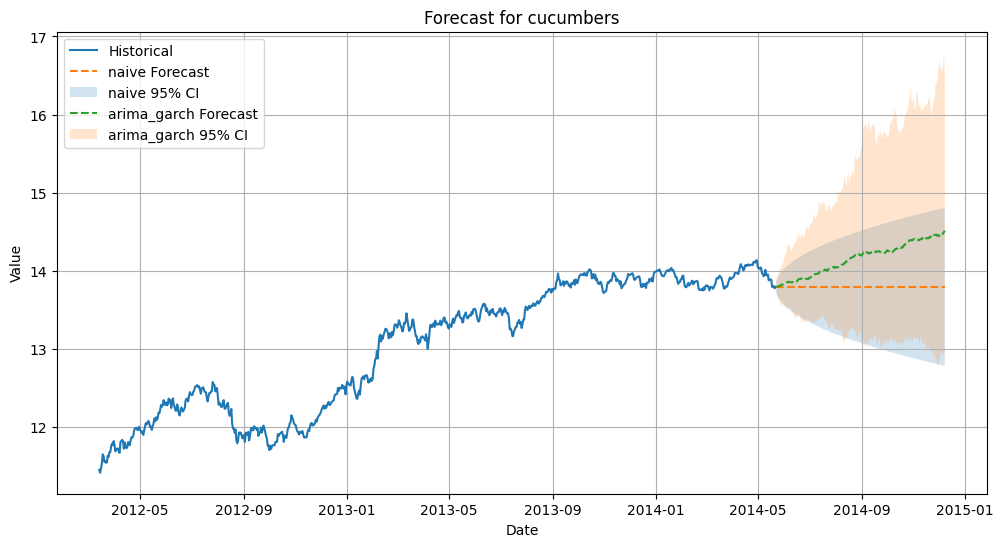

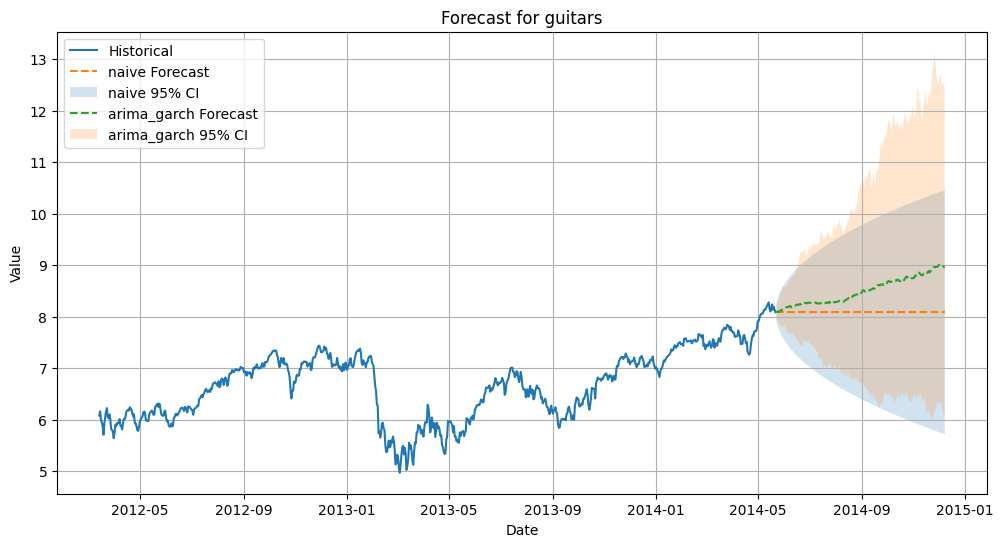

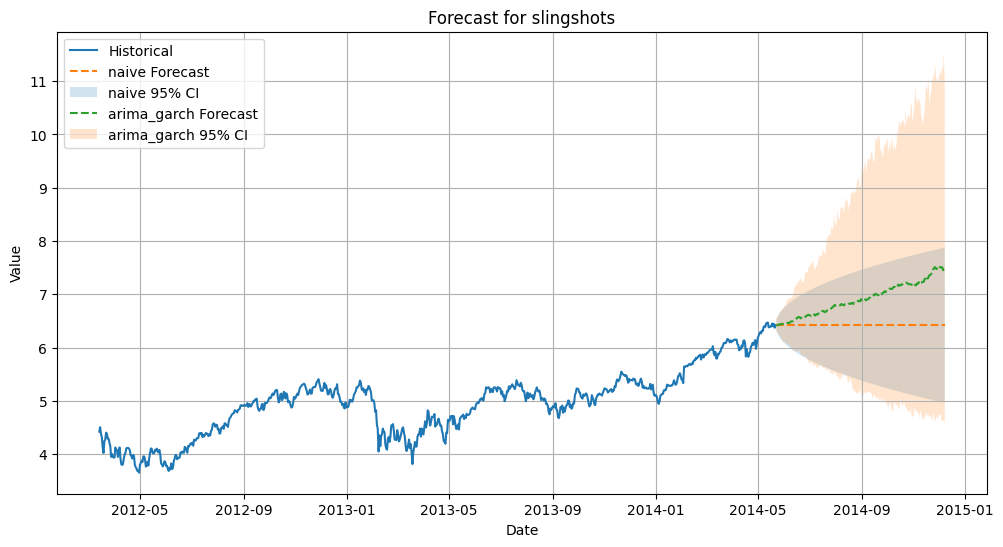

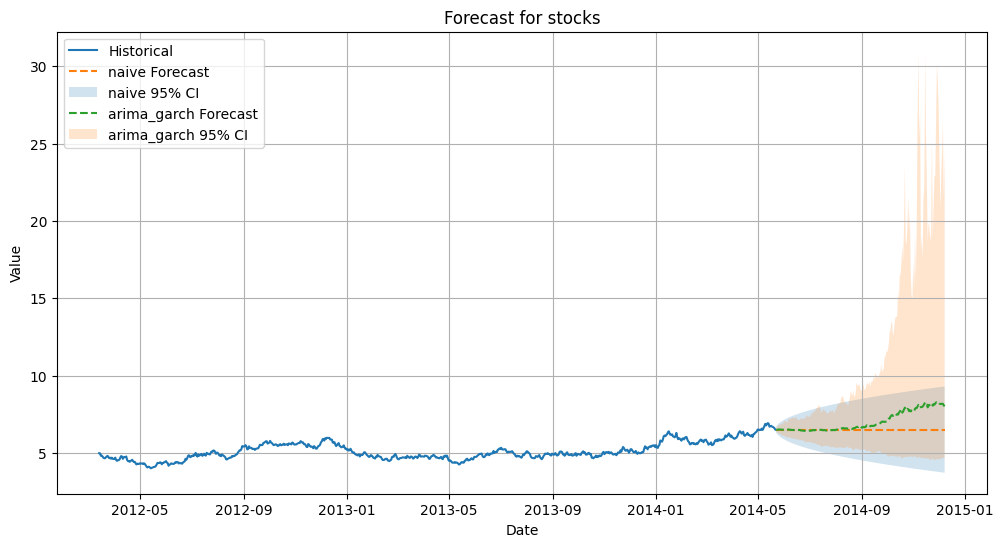

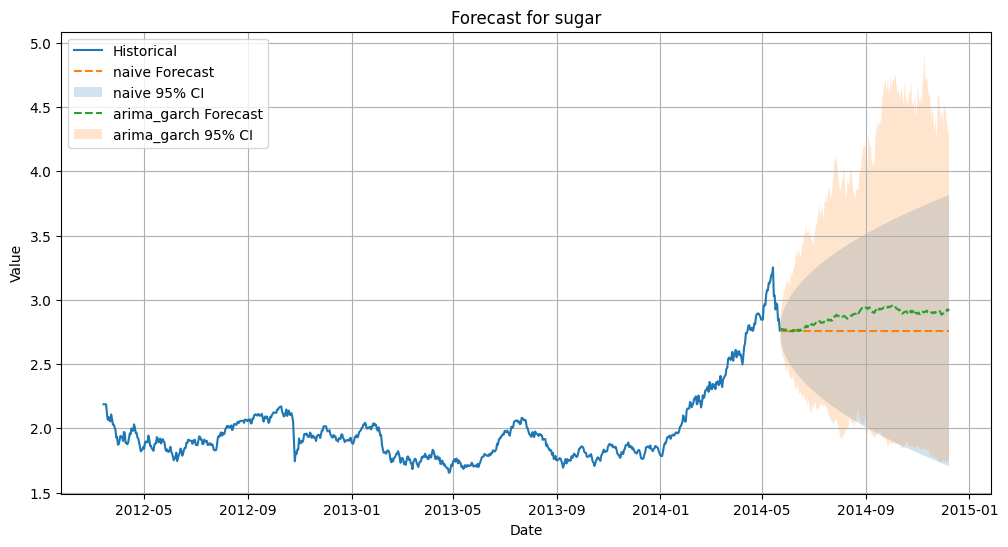

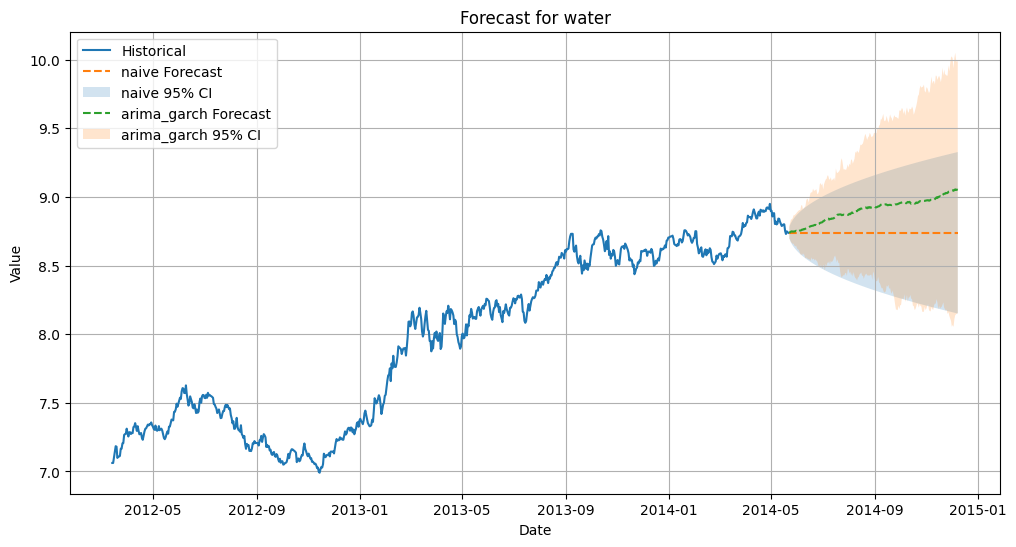

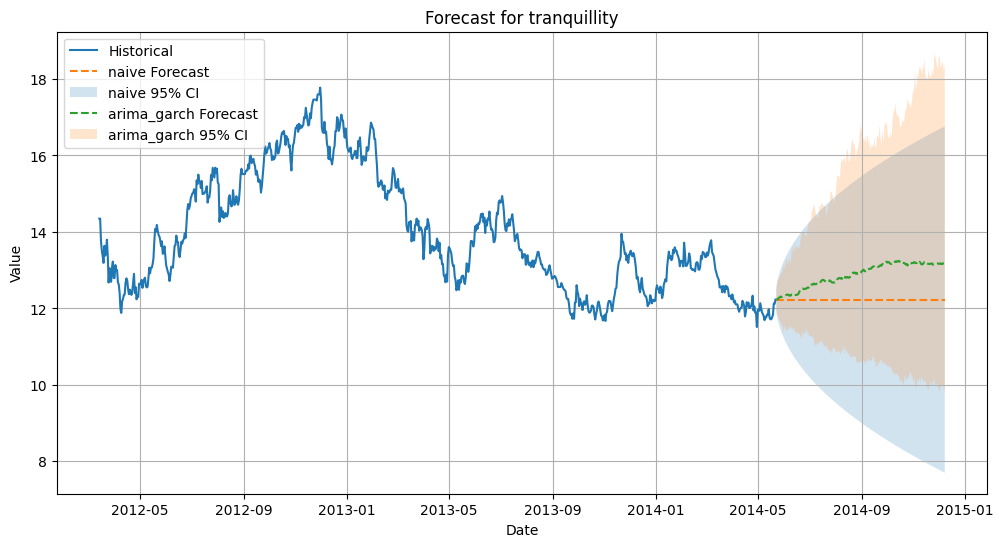

In [92]:
# Plot forecasts for each series
for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Get historical data
    historical_data = df_interpolated[series_name]
    historical_dates = historical_data.index

    # Get forecast data for all models
    forecast_data = [r for r in results if r['series'] == series_name and 'final_forecast' in r]

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(historical_dates[-800:], historical_data[-800:], label='Historical')

    # Plot each model's forecast
    for result in forecast_data:
        model = result['model']
        forecast = result['final_forecast']
        lower_bound = result['lower_bound']
        upper_bound = result['upper_bound']
        forecast_dates = result['forecast_dates']

        # Plot forecast
        plt.plot(forecast_dates, forecast[-200:], label=f'{model} Forecast', linestyle='--')
        # Plot confidence intervals
        plt.fill_between(forecast_dates, lower_bound[-200:], upper_bound[-200:], alpha=0.2, label=f'{model} 95% CI')

    plt.title(f'Forecast for {series_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)


# Rolling window with Monte Carlo, ARIMA+GARCH

## No BoxCox

In [97]:
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from collections import Counter
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# Suppress library version warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

results = []
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=200)

for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Prepare data
    train_data = df_interpolated[series_name][:-200]
    true_future = df_interpolated[series_name][-200:]

    # Ensure train_data has daily frequency
    train_data.index = pd.DatetimeIndex(train_data.index, freq='D')

    returns = np.log(train_data).diff().dropna()
    returns.index = pd.DatetimeIndex(returns.index).to_period('D').to_timestamp()

    # Check variance of returns
    returns_var = np.var(returns)
    print(f"Series {series_name}, Variance of returns: {returns_var}")
    if returns_var < 1e-6:
        print(f"⚠️ Warning: Low variance in returns for {series_name}, ARIMA may be unstable")

    # Lists to store metrics across folds
    fold_metrics = []

    # Rolling window CV
    for fold, (train_idx, test_idx) in enumerate(tscv.split(returns)):
        train_returns = returns.iloc[train_idx]
        train_prices = train_data.iloc[train_idx]
        test_prices = train_data.iloc[test_idx]

        # Naive baseline model
        naive_forecast = np.full(200, train_prices.iloc[-1])
        naive_rmse = np.sqrt(((naive_forecast - test_prices) ** 2).mean())
        naive_mae = mean_absolute_error(test_prices, naive_forecast)
        naive_mape = mean_absolute_percentage_error(test_prices, naive_forecast)
        fold_metrics.append({'fold': fold, 'model': 'naive', 'rmse': naive_rmse, 'mae': naive_mae, 'mape': naive_mape})

        # Prophet
        prophet_df = pd.DataFrame({
            'ds': train_prices.index,
            'y': train_prices.values})

        # ARIMA order selection
        # maybe get p and q to start_p = 1, start_q = 1 to avoid zero coefficients
        arima_model = auto_arima(train_returns, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
        arima_order = arima_model.order
        arima_result = ARIMA(train_returns, order=arima_order).fit()

        # Ljung - Box and ARCH-LM tests
        residuals = arima_result.resid.dropna()
        arch_needed = False
        if len(residuals) < 10 or np.isclose(residuals.var(), 0):
          print(f"Fold {fold}: Residuals too few / variance ~ 0 - skip tests.")
        else:
          max_lag = min(20, len(residuals) // 5)
          lb_p = acorr_ljungbox(residuals, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
          arch_p = het_arch(residuals, nlags=min(10, max_lag))[1]
          print(f"Fold {fold}, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
          print(f"Fold {fold}, ARCH-LM p={arch_p:.3f}")
          arch_needed = arch_p < 0.05

        # GARCH model

        # Default to zero if GARCH not needed
        garch_result = None
        var_garch = np.zeros(200)

        if arch_needed:
          garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 2), (2, 3), (3, 3)]
          best_garch_aic = float('inf')
          best_garch_order = None
          best_garch_result = None

          for garch_order in garch_orders:
              garch_model = arch_model(residuals, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
              garch_result = garch_model.fit(disp='off')

              if garch_result.aic < best_garch_aic:
                  best_garch_aic = garch_result.aic
                  best_garch_order = garch_order
                  best_garch_result = garch_result

          # Check GARCH stationarity (sum of alpha + beta < 1)
          alpha = best_garch_result.params.get('alpha[1]', 0)
          beta = best_garch_result.params.get('beta[1]', 0)
          if alpha + beta >= 1:
              print(f"⚠️ Warning: GARCH model may be non-stationary for {series_name}, fold {fold}, alpha + beta = {alpha + beta}")

          garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
          var_garch = garch_forecast.variance.values[-1, :]

        print(" -------- GARCH VARIANCE------ ")
        print(f"Fold {fold}, Max GARCH variance: {var_garch.max()}")

        # Forecasting
        horizon = 200
        n_simulations = 1000
        last_log_price = np.log(train_prices.iloc[-1])
        last_return = arima_result.resid.iloc[-1]

        phi = arima_result.params.get('ar.L1', 0)
        theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
        mu = arima_result.params.get('const', 0)
        eps_prev = [0.0] * arima_order[2] if arima_order[2] > 0 else []

        simulated_paths = np.zeros((n_simulations, horizon))
        for i in range(n_simulations):
            r_prev = last_return
            eps_hist = eps_prev.copy()
            sim_returns = []
            for t in range(horizon):
                std_dev = np.sqrt(var_garch[t] + 1e-8)
                eps_t = np.random.normal(0, std_dev)

                ma_part = sum(theta[j] * eps_hist[j] for j in range(len(theta))) if theta else 0

                r_t = mu + phi * r_prev + ma_part + eps_t

                sim_returns.append(r_t)
                r_prev = r_t
                eps_hist = [eps_t] + eps_hist[:-1]
            sim_log_prices = last_log_price + np.cumsum(sim_returns)
            simulated_paths[i, :] = np.exp(sim_log_prices)

        point_forecast = simulated_paths.mean(axis=0)
        print(f"Fold {fold}, Max simulated prices: {simulated_paths.max()}")
        print(f"Fold {fold}, Max point forecast: {point_forecast.max()}")

        # Metrics for this fold
        # fix these, should not be true future, use test_prices
        rmse = np.sqrt(((point_forecast - test_prices) ** 2).mean())
        mae = mean_absolute_error(test_prices, point_forecast)
        mape = mean_absolute_percentage_error(test_prices, point_forecast)

        fold_metrics.append({
            'fold': fold,
            'model': 'arima_garch',
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'arima_order': arima_order,
            'garch_order': best_garch_order if arch_needed else None
        })

    # Average metrics across folds
    metrics_df = pd.DataFrame(fold_metrics)
    avg_metrics = metrics_df.groupby('model')[['rmse', 'mae', 'mape']].mean().reset_index()

    # Store CV results
    for _, row in avg_metrics.iterrows():
        result = {
            'series': series_name,
            'model': row['model'],
            'rmse': row['rmse'],
            'mae': row['mae'],
            'mape': row['mape']
        }
        if row['model'] == 'arima_garch':
            # Get most frequent orders across folds
            arima_orders = [str(m['arima_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            garch_orders = [str(m['garch_order']) for m in fold_metrics if m['model'] == 'arima_garch']
            result['arima_order'] = eval(Counter(arima_orders).most_common(1)[0][0])
            result['garch_order'] = eval(Counter(garch_orders).most_common(1)[0][0])
        results.append(result)


    # ---------------  Final Forecasts ------------
    # Train on full df_interpolated and forecast 200 unknown values
    print("STARTING FINAL FORECAST ")
    full_train_data = df_interpolated[series_name]
    full_train_data.index = pd.DatetimeIndex(full_train_data.index, freq='D')
    returns = np.log(full_train_data).diff().dropna()
    returns.index = pd.DatetimeIndex(returns.index).to_period('D').to_timestamp(freq='D')

    # Generate future dates
    last_date = full_train_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=200, freq='D')

    # Naive Baseline
    naive_final_forecast = np.full(200, full_train_data.iloc[-1])
    hist_std = full_train_data.diff().dropna().std() * np.sqrt(np.arange(1, 201))  # Widening CI
    naive_lower_bound = naive_final_forecast - 1.96 * hist_std  # 95% CI
    naive_upper_bound = naive_final_forecast + 1.96 * hist_std

    results.append({
        'series': series_name,
        'model': 'naive',
        'final_forecast': naive_final_forecast,
        'lower_bound': naive_lower_bound,
        'upper_bound': naive_upper_bound,
        'forecast_dates': future_dates
    })

    # ARIMA + GARCH (re-run auto_arima and GARCH AIC on full data)
    arima_model = auto_arima(returns, seasonal=False, max_p=5, max_q=5, information_criterion='aic')
    arima_order = arima_model.order
    arima_result = ARIMA(returns, order=arima_order).fit()
    residuals = arima_result.resid.dropna()

    arch_needed = False
    if len(residuals) < 10 or np.isclose(residuals.var(), 0):
        print("Final Forecast: Residuals too few / variance ≈ 0 – skip tests.")
    else:
        max_lag = min(20, len(residuals)//5)
        lb_p = acorr_ljungbox(residuals, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
        arch_p = het_arch(residuals, nlags=min(10, max_lag))[1]
        print(f"Final Forecast, Ljung-Box p={lb_p:.3f} (lag {max_lag})")
        print(f"Final Forecast, ARCH-LM p={arch_p:.3f}")
        arch_needed = arch_p < 0.05

    garch_result = None
    var_garch = np.zeros(200)

    if arch_needed:
      garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2)]
      best_garch_aic = float('inf')
      best_garch_order = None
      best_garch_result = None

      for garch_order in garch_orders:
          garch_model = arch_model(residuals, vol='GARCH', p=garch_order[0], q=garch_order[1], rescale=False)
          garch_result = garch_model.fit(disp='off')
          if garch_result.aic < best_garch_aic:
              best_garch_aic = garch_result.aic
              best_garch_order = garch_order
              best_garch_result = garch_result

      if best_garch_result is not None:
            std_resid = best_garch_result.std_resid.dropna()

            # Ljung-Box on standardized residuals
            lb_p_post = acorr_ljungbox(std_resid, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]

            # ARCH-LM test on stadardized residuals
            arch_p_post = het_arch(std_resid, nlags=min(10, max_lag))[1]

            print(f"⚠️ Post-GARCH Ljung-Box p = {lb_p_post:.3f}")
            print(f"⚠️ Post-GARCH ARCH-LM p = {arch_p_post:.3f}")

      garch_forecast = best_garch_result.forecast(horizon=200, method='simulation')
      var_garch = garch_forecast.variance.values[-1, :]

    horizon = 200
    n_simulations = 1000
    last_log_price = np.log(full_train_data.iloc[-1])
    last_return = arima_result.resid.iloc[-1]

    phi = arima_result.params.get('ar.L1', 0)
    theta = [arima_result.params.get(f'ma.L{i}', 0) for i in range(1, arima_order[2] + 1)]
    mu = arima_result.params.get('const', 0)
    eps_prev = [0.0] * arima_order[2]


    simulated_paths = np.zeros((n_simulations, horizon))
    for i in range(n_simulations):

      r_prev = last_return  # Scalar for each simulation
      eps_prev = [0.0] * arima_order[2]  # History of shocks for this simulation
      sim_returns = []

      for t in range(horizon):
          std_dev = np.sqrt(var_garch[t])
          eps_t = np.random.normal(0, std_dev)  # Scalar shock for this simulation
          ma_part = sum(theta[j] * eps_prev[j] for j in range(arima_order[2])) if arima_order[2] > 0 else 0
          r_t = mu + phi * r_prev + ma_part + eps_t
          sim_returns.append(r_t)
          r_prev = r_t
          eps_prev = [eps_t] + eps_prev[:-1]

      sim_log_prices = last_log_price + np.cumsum(sim_returns)
      simulated_paths[i, :] = np.exp(sim_log_prices)

    print(f"Final Forecast, Max simulated prices: {simulated_paths.max()}")
    print(f"Final Forecast, Max point forecast: {simulated_paths.mean(axis=0).max()}")

    arima_garch_final_forecast = simulated_paths.mean(axis=0)
    arima_garch_lower_bound = np.percentile(simulated_paths, 5, axis=0)
    arima_garch_upper_bound = np.percentile(simulated_paths, 95, axis=0)
    results.append({
        'series': series_name,
        'model': 'arima_garch',
        'final_forecast': arima_garch_final_forecast,
        'lower_bound': arima_garch_lower_bound,
        'upper_bound': arima_garch_upper_bound,
        'forecast_dates': future_dates,
        'arima_order': arima_order,
        'garch_order': best_garch_order if arch_needed else None
    })


# Summary of CV results
results_df = pd.DataFrame([r for r in results if 'rmse' in r])
print("Cross-Validation Results Summary:")
print(results_df[['series', 'model', 'rmse', 'mae', 'mape', 'arima_order', 'garch_order']])

# Final forecasts
forecast_df = pd.DataFrame([r for r in results if 'final_forecast' in r])
print("\nFinal Forecasts:")
print(forecast_df[['series', 'model', 'final_forecast', 'lower_bound', 'upper_bound']])

Series cucumbers, Variance of returns: 1.5827989170076743e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Fold 0, Ljung-Box p=0.445 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 7.73471698658061e-05
Fold 0, Max simulated prices: 13.996030904410734
Fold 0, Max point forecast: 10.94245887516725
Fold 1, Ljung-Box p=0.070 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 2.985629168612419e-05
Fold 1, Max simulated prices: 13.914726901565716
Fold 1, Max point forecast: 11.261108502375835
Fold 2, Ljung-Box p=0.124 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 1.6677654064952518e-05
Fold 2, Max simulated prices: 14.15994039991955
Fold 2, Max point forecast: 11.987715510474924
Fold 3, Ljung-Box p=0.046 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 2.186869775950637e-05
Fold 3, Max simulated prices: 14.736200518919219
Fold 3, Max point forecast: 12.19297180740622
Fold 4, Ljung-Box p=0.062 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 1.9664266656813296e-05
Fold 4, Max simulated prices: 16.553030367834396
Fold 4, Max point forecast: 13.747433510541926
STARTING FINAL FORECAST 


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Final Forecast, Ljung-Box p=0.064 (lag 20)
Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


⚠️ Post-GARCH Ljung-Box p = 0.108
⚠️ Post-GARCH ARCH-LM p = 0.428
Final Forecast, Max simulated prices: 16.77649351071083
Final Forecast, Max point forecast: 14.521398123964238
Series guitars, Variance of returns: 0.0002254188941233319
Fold 0, Ljung-Box p=0.072 (lag 20)
Fold 0, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0009024053511865983
Fold 0, Max simulated prices: 12.25604561245274
Fold 0, Max point forecast: 5.656652730653045
Fold 1, Ljung-Box p=0.005 (lag 20)
Fold 1, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.00027524517458202546
Fold 1, Max simulated prices: 10.206448876290304
Fold 1, Max point forecast: 5.216992357952325
Fold 2, Ljung-Box p=0.002 (lag 20)
Fold 2, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.0002091978128747526
Fold 2, Max simulated prices: 12.035243550808818
Fold 2, Max point forecast: 6.401934552355229
Fold 3, Ljung-Box p=0.010 (lag 20)
Fold 3, ARCH-LM p=0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Final Forecast, Ljung-Box p=0.001 (lag 20)
Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.350
⚠️ Post-GARCH ARCH-LM p = 0.506
Final Forecast, Max simulated prices: 16.28943846028157
Final Forecast, Max point forecast: 8.580801597225685
Series slingshots, Variance of returns: 0.00021955795572236217
Fold 0, Ljung-Box p=0.739 (lag 20)
Fold 0, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0017363633943942617
Fold 0, Max simulated prices: 61.29090474854373
Fold 0, Max point forecast: 4.387961911998527


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 1, Ljung-Box p=0.012 (lag 20)
Fold 1, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.0002904918043608666
Fold 1, Max simulated prices: 7.149415011046461
Fold 1, Max point forecast: 3.290243229092708


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 2, Ljung-Box p=0.022 (lag 20)
Fold 2, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.00019761732379356106
Fold 2, Max simulated prices: 8.113352530013973
Fold 2, Max point forecast: 4.636905633187049


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 3, Ljung-Box p=0.016 (lag 20)
Fold 3, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.00019904073117249288
Fold 3, Max simulated prices: 9.825356399243123
Fold 3, Max point forecast: 5.214397285283573


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 4, Ljung-Box p=0.000 (lag 20)
Fold 4, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.0005680791013498414
Fold 4, Max simulated prices: 11.765849475014928
Fold 4, Max point forecast: 4.849317106996016
STARTING FINAL FORECAST 
Final Forecast, Ljung-Box p=0.015 (lag 20)
Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.003
⚠️ Post-GARCH ARCH-LM p = 0.961
Final Forecast, Max simulated prices: 10.040453373661888
Final Forecast, Max point forecast: 6.649969108203007
Series stocks, Variance of returns: 0.00021966421013982172


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 0, Ljung-Box p=0.988 (lag 20)
Fold 0, ARCH-LM p=0.433
 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0
Fold 0, Max simulated prices: 4.749384342396259
Fold 0, Max point forecast: 4.747947702368494
Fold 1, Ljung-Box p=0.982 (lag 20)
Fold 1, ARCH-LM p=0.572
 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.0
Fold 1, Max simulated prices: 4.593510186708058
Fold 1, Max point forecast: 4.59168710455569
Fold 2, Ljung-Box p=0.994 (lag 20)
Fold 2, ARCH-LM p=0.715
 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.0
Fold 2, Max simulated prices: 4.982212049857297
Fold 2, Max point forecast: 4.980359287496719
Fold 3, Ljung-Box p=0.990 (lag 20)
Fold 3, ARCH-LM p=0.804
 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.0
Fold 3, Max simulated prices: 5.761971129288392
Fold 3, Max point forecast: 5.759919430613636
Fold 4, Ljung-Box p=0.991 (lag 20)
Fold 4, ARCH-LM p=0.759
 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.0
Fold 4, Ma

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Fold 0, Ljung-Box p=0.323 (lag 20)
Fold 0, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 2.9473710788645465e-05
Fold 0, Max simulated prices: 7.819009529320514
Fold 0, Max point forecast: 6.554648151209398
Fold 1, Ljung-Box p=0.099 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 1.4107815366851504e-05
Fold 1, Max simulated prices: 8.118118761287702
Fold 1, Max point forecast: 6.862409951415231
Fold 2, Ljung-Box p=0.110 (lag 20)
Fold 2, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 1.1312317216513924e-05
Fold 2, Max simulated prices: 8.439359225104884
Fold 2, Max point forecast: 7.220120326928317
Fold 3, Ljung-Box p=0.192 (lag 20)
Fold 3, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 1.2094999157901806e-05
Fold 3, Max simulated prices: 8.595269465851986
Fold 3, Max point forecast: 7.2852808777319495
Fold 4, Ljung-Box p=0.121 (lag 20)
Fold 4, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 4.6573857493797474e-05
Fold 4, Max simulated prices: 10.78089104008471
Fold 4, Max point forecast: 8.433409664941957
STARTING FINAL FORECAST 


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


Final Forecast, Ljung-Box p=0.313 (lag 20)
Final Forecast, ARCH-LM p=0.000
⚠️ Post-GARCH Ljung-Box p = 0.737
⚠️ Post-GARCH ARCH-LM p = 0.757


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Final Forecast, Max simulated prices: 10.633291609747687
Final Forecast, Max point forecast: 8.991255587305037
Series tranquillity, Variance of returns: 0.00015742639415925125
Fold 0, Ljung-Box p=0.410 (lag 20)
Fold 0, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 0, Max GARCH variance: 0.0003339619063909959
Fold 0, Max simulated prices: 161.38426216959988
Fold 0, Max point forecast: 19.84904272841854
Fold 1, Ljung-Box p=0.307 (lag 20)
Fold 1, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


 -------- GARCH VARIANCE------ 
Fold 1, Max GARCH variance: 0.0004398156318029496
Fold 1, Max simulated prices: 450.59856443491077
Fold 1, Max point forecast: 15.345630755404862
Fold 2, Ljung-Box p=0.152 (lag 20)
Fold 2, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 2, Max GARCH variance: 0.00042154335044718296
Fold 2, Max simulated prices: 29.836264267713716
Fold 2, Max point forecast: 14.634993242187958
Fold 3, Ljung-Box p=0.109 (lag 20)
Fold 3, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 3, Max GARCH variance: 0.00016192446466314534
Fold 3, Max simulated prices: 30.98963767641386
Fold 3, Max point forecast: 16.991919535274985
Fold 4, Ljung-Box p=0.047 (lag 20)
Fold 4, ARCH-LM p=0.000
 -------- GARCH VARIANCE------ 
Fold 4, Max GARCH variance: 0.00027229172758803146
Fold 4, Max simulated prices: 26.153917502971748
Fold 4, Max point forecast: 14.154118407677794
STARTING FINAL FORECAST 
Final Forecast, Ljung-Box p=0.057 (lag 20)
Final Forecast, ARCH-LM p=0.000


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


⚠️ Post-GARCH Ljung-Box p = 0.062
⚠️ Post-GARCH ARCH-LM p = 0.816
Final Forecast, Max simulated prices: 21.632334451708292
Final Forecast, Max point forecast: 12.68319415986244
Cross-Validation Results Summary:
          series        model      rmse       mae      mape arima_order  \
0      cucumbers  arima_garch  0.427466  0.349600  0.028815   (1, 0, 2)   
1      cucumbers        naive  0.603771  0.527199  0.043276         NaN   
2        guitars  arima_garch  0.714294  0.589850  0.109338   (0, 0, 0)   
3        guitars        naive  0.734892  0.604169  0.108525         NaN   
4     slingshots  arima_garch  0.620295  0.547598  0.157971   (2, 0, 2)   
5     slingshots        naive  0.514113  0.450496  0.118512         NaN   
6         stocks  arima_garch  0.500197  0.429101  0.085644   (0, 0, 0)   
7         stocks        naive  0.497413  0.422601  0.085209         NaN   
8          sugar  arima_garch  0.239863  0.212120  0.116881   (3, 0, 2)   
9          sugar        naive  0.230337

In [98]:
results_df

,series,model,rmse,mae,mape,arima_order,garch_order
0,cucumbers,arima_garch,0.427466,0.349600,0.028815,"(1, 0, 2)","(2, 3)"
1,cucumbers,naive,0.603771,0.527199,0.043276,NaN,NaN
2,guitars,arima_garch,0.714294,0.589850,0.109338,"(0, 0, 0)","(3, 3)"
3,guitars,naive,0.734892,0.604169,0.108525,NaN,NaN
4,slingshots,arima_garch,0.620295,0.547598,0.157971,"(2, 0, 2)","(2, 3)"
5,slingshots,naive,0.514113,0.450496,0.118512,NaN,NaN
6,stocks,arima_garch,0.500197,0.429101,0.085644,"(0, 0, 0)",None
7,stocks,naive,0.497413,0.422601,0.085209,NaN,NaN
8,sugar,arima_garch,0.239863,0.212120,0.116881,"(3, 0, 2)","(2, 1)"
9,sugar,naive,0.230337,0.200665,0.110324,NaN,NaN


In [100]:
forecast_df

,series,model,final_forecast,lower_bound,upper_bound,forecast_dates,arima_order,garch_order
0,cucumbers,naive,"[13.79194942177011, 13.79194942177011, 13.7919...","[13.720359948451321, 13.690706617679533, 13.66...","[13.863538895088897, 13.893192225860686, 13.91...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
1,cucumbers,arima_garch,"[13.798802254441886, 13.80025379757955, 13.806...","[13.7288879884668, 13.707641592102817, 13.6883...","[13.868621458513536, 13.901691617020857, 13.93...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(1, 0, 2)","(2, 1)"
2,guitars,naive,"[8.08491746257293, 8.08491746257293, 8.0849174...","[7.9173134493709725, 7.847889593994562, 7.7946...","[8.252521475774888, 8.321945331151298, 8.37521...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
3,guitars,arima_garch,"[8.083876349538427, 8.082149297989313, 8.08235...","[7.9569467866454735, 7.9105601789050715, 7.878...","[8.21058736466172, 8.259003103122005, 8.303852...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(0, 0, 0)","(2, 1)"
4,slingshots,naive,"[6.419011268155251, 6.419011268155251, 6.41901...","[6.31587819759022, 6.273159081033004, 6.240379...","[6.522144338720282, 6.564863455277498, 6.59764...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
5,slingshots,arima_garch,"[6.404992718760475, 6.411277646273347, 6.40770...","[6.315803209959088, 6.293293041604189, 6.27952...","[6.493377241352565, 6.530019903953262, 6.53404...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(2, 0, 2)","(2, 2)"
6,stocks,naive,"[6.512971260506997, 6.512971260506997, 6.51297...","[6.315959398297992, 6.234354413022643, 6.17173...","[6.709983122716001, 6.79158810799135, 6.854205...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
7,stocks,arima_garch,"[6.512328863994922, 6.511686530844368, 6.51104...","[6.512328863994762, 6.511686530844279, 6.51104...","[6.512328863994762, 6.511686530844279, 6.51104...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(0, 0, 0)",None
8,sugar,naive,"[2.7605914238498537, 2.7605914238498537, 2.760...","[2.6860292273727655, 2.655144554351628, 2.6314...","[2.835153620326942, 2.8660382933480792, 2.8897...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...",NaN,NaN
9,sugar,arima_garch,"[2.7947050008387575, 2.782102692567428, 2.7901...","[2.6804050730889357, 2.632539495005823, 2.5674...","[2.914606808414148, 2.9475370531142664, 3.0328...","DatetimeIndex(['2014-05-23', '2014-05-24', '20...","(3, 0, 2)","(2, 1)"


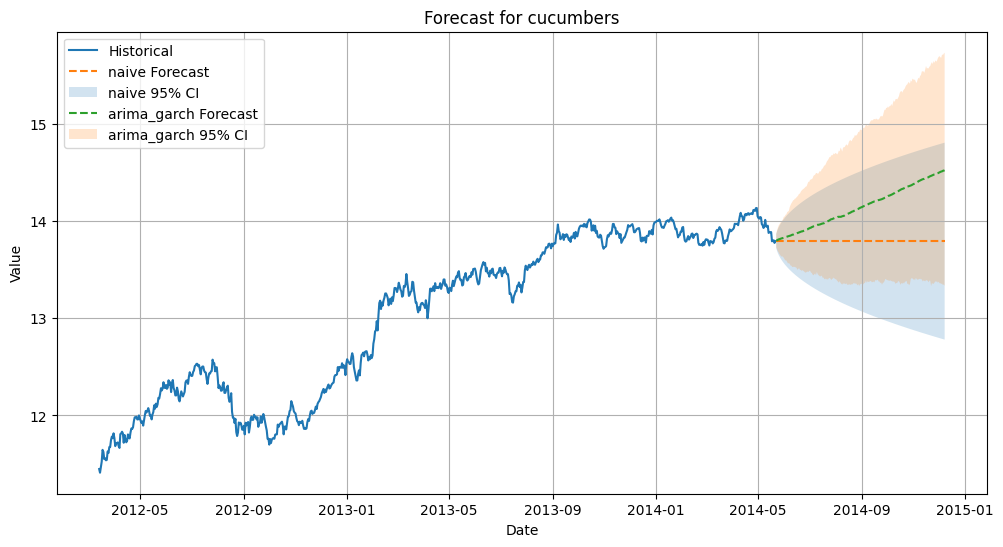

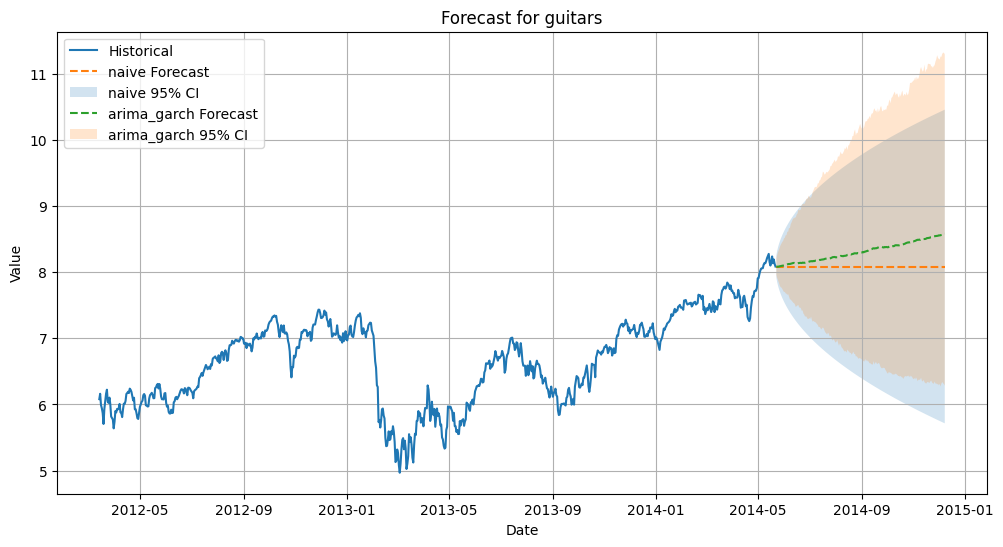

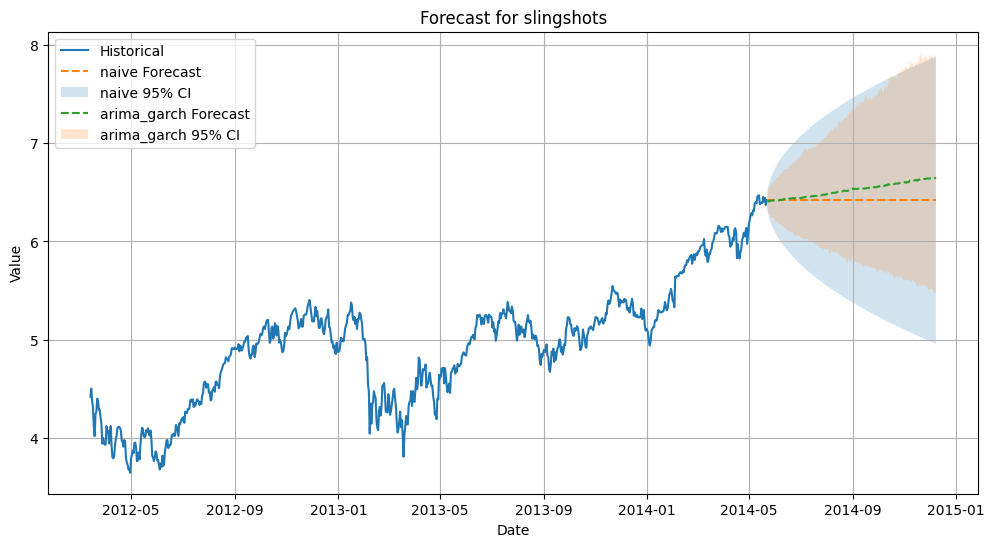

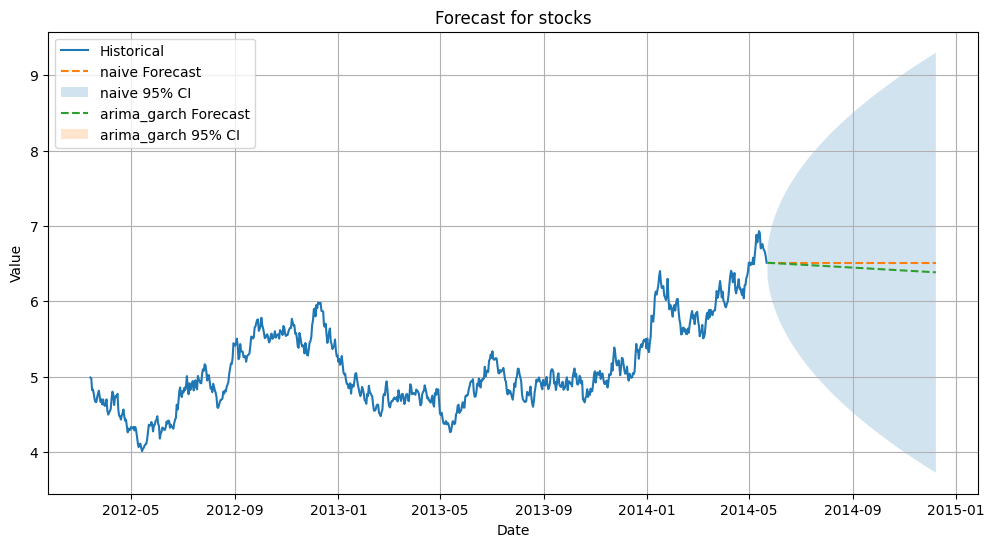

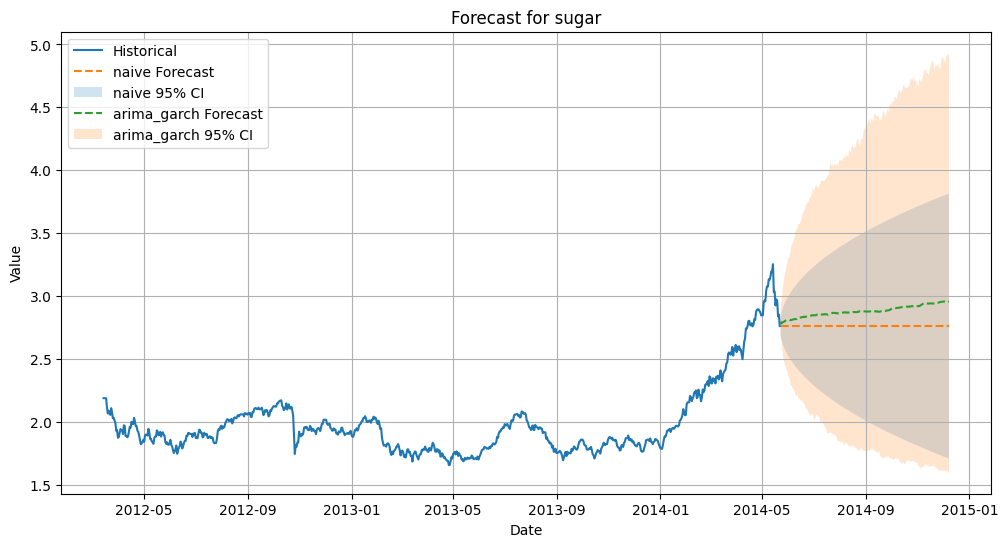

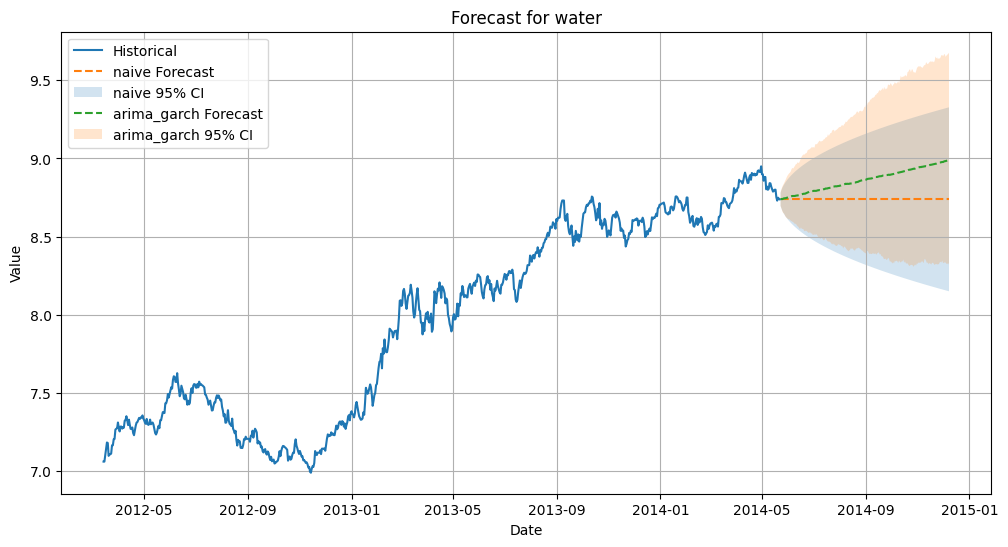

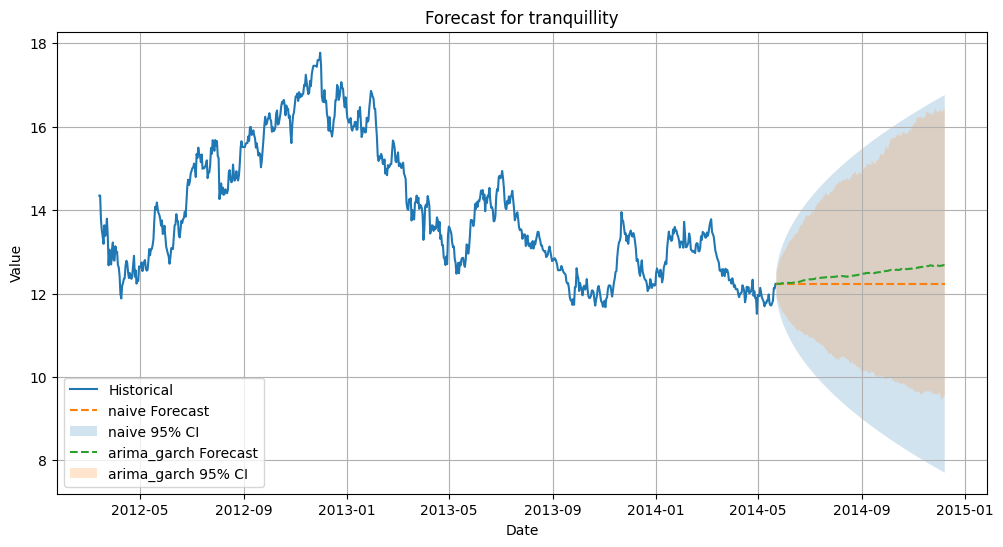

In [101]:
# Plot forecasts for each series
for series_name in df_interpolated.columns:
    if series_name == 'day':
        continue

    # Get historical data
    historical_data = df_interpolated[series_name]
    historical_dates = historical_data.index

    # Get forecast data for all models
    forecast_data = [r for r in results if r['series'] == series_name and 'final_forecast' in r]

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(historical_dates[-800:], historical_data[-800:], label='Historical')

    # Plot each model's forecast
    for result in forecast_data:
        model = result['model']
        forecast = result['final_forecast']
        lower_bound = result['lower_bound']
        upper_bound = result['upper_bound']
        forecast_dates = result['forecast_dates']

        # Plot forecast
        plt.plot(forecast_dates, forecast[-200:], label=f'{model} Forecast', linestyle='--')
        # Plot confidence intervals
        plt.fill_between(forecast_dates, lower_bound[-200:], upper_bound[-200:], alpha=0.2, label=f'{model} 95% CI')

    plt.title(f'Forecast for {series_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)


## Rolling window CV

TimeSeriesSplit is designed for time series CV. Ensures that the training set always preceds the test set, respect the temporal order of the data.

- n_splits = k, creates k folds each with a training set and a test set. The training set grows with each fold, and the tes set slides forward in time.

In our case:

5200 observations. (-1 from .diff()), splits = 5

- Training set size: Increases with each fold, calculated as:
  - Total number of observations is divided such that the last fold's test set ends the final observation
  - Training set size for each fold is determined by ensuring the test sets cover the last 5 * 200 = 1000 observations.

Splits are computed as:

Split 1:
- Train: Indices 0 to 4,199 (first 4,200 observations).
- Test: Indices 4,200 to 4,399 (next 200 observations).

Split 2:
- Train: Indices 0 to 4,399 (first 4,400 observations).
- Test: Indices 4,400 to 4,599 (next 200 observations).

Split 3:
- Train: Indices 0 to 4,599 (first 4,600 observations).
- Test: Indices 4,600 to 4,799 (next 200 observations).

Split 4:
- Train: Indices 0 to 4,799 (first 4,800 observations).
- Test: Indices 4,800 to 4,999 (next 200 observations).

Split 5:
- Train: Indices 0 to 4,999 (first 5,000 observations).
- Test: Indices 5,000 to 5,199 (last 200 observations).


## Calculation Details
- The test sets cover the last 1,000 observations (5 splits × 200 test observations).

- The first test set starts at index 5,199 - 1,000 = 4,199 (after the first 4,200 observations).

- Each subsequent test set shifts forward by 200 observations.

- The training set grows by 200 observations per fold, starting from 4,200 in the first fold to 5,000 in the last fold.


## Final Forecast:
In time series forecasting, CV is used for evaluation and model selection, but the final forecast typically uses the full dataset to maximize predictive power. This is especially important for long-horizon forecasts (our 200 steps), where small improvements in parameter estimates can compound over time.

# CV is not redundant

Rolling window CV is not redundant, even if we re-fit the model on the full dataset, because it serves a different purpose than the final forecast:

- CV Purpose: Evaluate and compare models (ARIMA + GARCH, baseline, Prophet) and validate parameter choices across multiple periods to ensure robustness and generalization.

- Final Forecast Purpose: Produce the most accurate 200-step-ahead predictions using all available data.

Without CV, we have no reliable way to:

- Compare ARIMA + GARCH against baseline or Prophet models.

- Assess whether the model generalizes across different periods of our data.

- Detect potential issues like overfitting or unstable parameter selection.



# IMRPOVEMENTS OF FORECAST

Instead of using all data which contains crashes, limit the data to stable periods, might better model the future.